<a href="https://colab.research.google.com/github/talalba/covid19/blob/master/covid_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
# load necessat packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [111]:
# get owid data
data_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(data_url,parse_dates=['date'],index_col=['date'])

display(df)




,iso_code,continent,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,AFG,Asia,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2020-01-01,AFG,Asia,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2020-01-02,AFG,Asia,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2020-01-03,AFG,Asia,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2020-01-04,AFG,Asia,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,NaN,NaN,International,705.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,International,705.0,0.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,International,705.0,0.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
# find the stats for last week

# get data for given date
df_latest = df.loc['2020-06-29':'2020-06-29']

# # define new features

# df_latest['total_tests_per_million'] = df_latest['total_tests_per_thousand']*1e3

# # cases as a fraction of the tests done
# df_latest['cases_test'] = (df_latest['total_cases_per_million']/df_latest['total_tests_per_million'])*1e6


# select features for analysis 
# we used normalized features so that they are not influenced by population size

features = ['iso_code', 'continent', 'location',
         'population_density', 'median_age','total_cases_per_million',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cvd_death_rate', 'diabetes_prevalence','life_expectancy']


# features = ['iso_code', 'continent', 'location','cases_test','gdp_per_capita',
#        'cvd_death_rate', 'diabetes_prevalence']       

df_latest = df_latest[features]

# keep countries with complete information
df2 = df_latest.dropna(axis=0)

df3 = df2.drop(['iso_code', 'continent', 'location'],axis=1)

# this is the number oc countried for which we have complete data
print(df3.shape)



(172, 9)


In [230]:
# show stats of the features
df3.describe()

,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,206.667273,30.330233,1820.245523,8.659395,5.517349,18723.196901,256.857686,7.655174,72.654477
std,644.910406,9.057007,3473.079761,6.220859,4.269091,19593.302945,117.565378,3.885562,7.507183
min,1.980000,15.100000,1.229000,1.144000,0.526000,661.240000,79.370000,0.990000,53.280000
25%,35.811250,22.150000,112.628000,3.397750,2.014750,4394.331000,168.357000,4.955000,67.092500
50%,82.024500,29.600000,575.030500,6.258500,3.845000,12265.791000,243.229500,7.110000,74.165000
75%,206.285750,38.400000,2219.372000,13.990500,8.800250,26910.234250,323.446250,9.907500,77.925000
max,7915.731000,48.200000,32770.230000,27.049000,18.493000,116935.600000,724.417000,22.020000,84.630000


Find the optimal number of clusters for k means, within cluster sum of squares is used as a measure to find the optimal K 

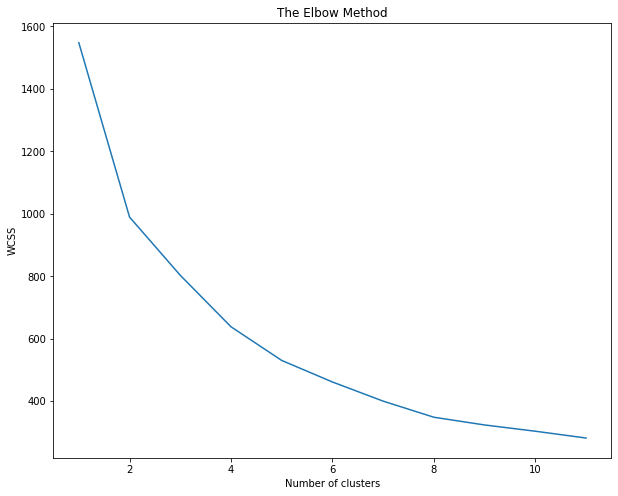

In [209]:
#standardize the data to normal distribution
# this ensures that features are treated equally in clustering distance measure
df3_standardized = preprocessing.scale(df3)
df3_standardized = pd.DataFrame(df3_standardized)

# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df3_standardized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 12), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



6 clusters seems to be an optimal, as after that WCSS doesnot change much

In [245]:
# Fitting K-Means to the dataset

no_clusters = 6 
kmeans = KMeans(n_clusters = no_clusters , init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df3_standardized)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
df3['cluster'] = cluster.values


for each cluster, get the mean values of all features 

In [249]:
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(df3.groupby('cluster').mean(),1))
display(kmeans_mean_cluster)
df2['cluster'] = cluster.values

,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy
cluster,,,,,,,,,
1,98.3,20.1,504.1,3.3,1.9,4308.9,274.8,4.5,63.5
2,225.3,31.2,1450.9,8.0,4.9,15296.4,216.3,10.1,75.5
3,366.1,32.9,12881.9,3.4,2.0,57546.2,204.6,15.0,77.7
4,95.6,27.7,640.4,6.0,3.7,8010.0,465.6,9.0,70.1
5,7915.7,42.4,7428.5,12.9,7.0,85535.4,92.2,11.0,83.6
6,161.6,42.1,2467.6,18.0,12.0,37513.0,187.0,6.5,80.4


We now look at the charcatertics of the 6 clusters

1. Cluster 4 has the highest death rate, lowest median age and and very low GDP. This includes primarily 3rd world countries in Asia and Africa.

2. Cluster 5 is very intersting. It has the highest population density, lowest death rate with high diabaetes and the highest averge GDP. If we look closey this cluster has only country Singapore. Even with the highest diabaetes rate and highest population density it seems to be dealing with COVID very well. This patterns is very distinct that it forms its own unique cluster. It suggests that diabetes prevelance alone doesnot explain high detah rate. In this GDP seems to be playing a part, having better access to facilities as well as government policies. 



In [266]:
# display a specific cluster
df2[df2['cluster']==5]

,iso_code,continent,location,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy,cluster
date,,,,,,,,,,,,,
2020-06-29,SGP,Asia,Singapore,7915.731,42.4,7428.453,12.922,7.049,85535.383,92.243,10.99,83.62,5


In [226]:
# dispay the head of countries in each cluster 
[display(df2[df2['cluster']==x].head()) for x in range(1,no_clusters)]


,iso_code,continent,location,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy,cluster
date,,,,,,,,,,,,,
2020-06-29,AGO,Africa,Angola,23.890,16.8,8.124,2.405,1.362,5819.495,276.045,3.94,61.15,1
2020-06-29,BEN,Africa,Benin,99.110,18.8,94.777,3.244,1.942,2064.236,235.848,0.99,61.77,1
2020-06-29,BWA,Africa,Botswana,4.044,25.8,53.155,3.941,2.242,15807.374,237.372,4.81,69.59,1
2020-06-29,BFA,Africa,Burkina Faso,70.151,17.6,45.878,2.409,1.358,1703.102,269.048,2.42,61.58,1
2020-06-29,BDI,Africa,Burundi,423.062,17.5,14.297,2.562,1.504,702.225,293.068,6.05,61.58,1


,iso_code,continent,location,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy,cluster
date,,,,,,,,,,,,,
2020-06-29,ALB,Europe,Albania,104.871,38.0,834.665,13.188,8.643,11803.431,304.195,10.08,78.57,2
2020-06-29,DZA,Africa,Algeria,17.348,29.1,302.684,6.211,3.857,13913.839,278.364,6.73,76.88,2
2020-06-29,ATG,North America,Antigua and Barbuda,231.845,32.1,663.753,6.933,4.631,21490.943,191.511,13.17,77.02,2
2020-06-29,ARG,South America,Argentina,16.177,31.9,1277.354,11.198,7.441,18933.907,191.032,5.50,76.67,2
2020-06-29,ARM,Asia,Armenia,102.931,35.7,8479.587,11.232,7.571,8787.580,341.010,7.11,75.09,2


,iso_code,continent,location,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy,cluster
date,,,,,,,,,,,,,
2020-06-29,BHR,Asia,Bahrain,1935.907,32.4,15106.521,2.372,1.387,43290.705,151.689,16.52,77.29,3
2020-06-29,CHL,South America,Chile,24.282,35.4,14227.821,11.087,6.938,22767.037,127.993,8.46,80.18,3
2020-06-29,KWT,Asia,Kuwait,232.128,33.7,10523.671,2.345,1.114,65530.537,132.235,15.84,75.49,3
2020-06-29,OMN,Asia,Oman,14.980,30.7,7470.692,2.355,1.530,37960.709,266.342,12.61,77.86,3
2020-06-29,QAT,Asia,Qatar,227.322,31.9,32770.230,1.307,0.617,116935.600,176.690,16.52,80.23,3


,iso_code,continent,location,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy,cluster
date,,,,,,,,,,,,,
2020-06-29,AFG,Asia,Afghanistan,54.422,18.6,795.487,2.581,1.337,1803.987,597.029,9.59,64.83,4
2020-06-29,AZE,Asia,Azerbaijan,119.309,32.4,1619.856,6.018,3.871,15847.419,559.812,7.11,73.00,4
2020-06-29,EGY,Africa,Egypt,97.999,25.3,637.010,5.159,2.891,10550.206,525.432,17.31,71.99,4
2020-06-29,FJI,Oceania,Fiji,49.562,28.6,20.079,6.224,3.284,8702.975,412.820,14.49,67.44,4
2020-06-29,GEO,Asia,Georgia,65.032,38.7,232.128,14.864,10.244,9745.079,496.218,7.11,73.77,4


,iso_code,continent,location,population_density,median_age,total_cases_per_million,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,life_expectancy,cluster
date,,,,,,,,,,,,,
2020-06-29,SGP,Asia,Singapore,7915.731,42.4,7428.453,12.922,7.049,85535.383,92.243,10.99,83.62,5


[None, None, None, None, None]